# Avacado Prices Analysis And Forecasting

### Python Libraries

In [987]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier,RandomForestRegressor,GradientBoostingRegressor,ExtraTreesRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,KFold,RepeatedStratifiedKFold,train_test_split,learning_curve
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler,RobustScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import accuracy_score,mean_squared_error

from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgbm
from sklearn import utils
from lightgbm.sklearn import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [988]:
avacado=pd.read_csv("./data/input/avocado.csv")
df=avacado.copy()
df.drop_duplicates()
df

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


**Alright,We need to auxiliary functions in order to get better coding concept.Let's describe it. :=)**

In [989]:
def load(dataset_path):
    data = pd.read_csv(dataset_path)
    return data
def data_sampling(dataframe):
    seedcount=int(len(dataframe)/8)
    np.random.seed(seedcount)
    return dataframe.sample(n=seedcount,random_state=1,replace=True)

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)

    print("##################### Types #####################")
    print(dataframe.dtypes)

    print("##################### Head #####################")
    print(dataframe.head(head))

    print("##################### Tail #####################")
    print(dataframe.tail(head))

    print("##################### NA #####################")
    print(dataframe.isnull().sum())

    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def grab_col_names(dataframe, cat_th=12, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car,num_but_cat

def cat_summary(dataframe, col_name, plot=False):

    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

def num_summary(dataframe, numerical_col, plot=False):

    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]

    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def target_summary_with_cat(dataframe, target, categorical_col):

    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")


def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

def label_encoder(dataframe, binary_col):
    le = LabelEncoder()
    for i in binary_col:
        dataframe[i]=le.fit_transform(df[i])
    return dataframe

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
def plot_importance(model, features, num, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
def showlineplot(style, x, y, dataframe, alhp,rot,color, xlabel, ylabel, title):
    sns.set_style(style)
    sns.lineplot(x=x,
                 y=y,
                 data=dataframe,
                 alpha=alhp,
                 color=color
                 )
    plt.xticks(rotation=rot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

**We have 18249 observations.We need to edit that tiny problem.This problem will be arising issue in next times.Therefore,we are diving to data sampling.Yaaay!**

## Data Sampling

In [990]:
df=data_sampling(df)

In [991]:
check_df(df)

##################### Shape #####################
(2281, 14)
##################### Types #####################
Unnamed: 0        int64
Date             object
AveragePrice    float64
Total Volume    float64
4046            float64
4225            float64
4770            float64
Total Bags      float64
Small Bags      float64
Large Bags      float64
XLarge Bags     float64
type             object
year              int64
region           object
dtype: object
##################### Head #####################
       Unnamed: 0        Date  AveragePrice  Total Volume        4046  \
235            27  2015-06-21          1.24     543504.66     3582.45   
12172          31  2016-05-22          1.57      18030.82        8.23   
5192           44  2016-02-21          0.82    5108381.41  2872173.10   
17289           4  2017-12-03          1.81       6102.50      804.30   
10955           9  2015-10-25          1.64      30717.28     3595.24   

             4225       4770  Total Bags  Small Bag

- Finally,we have minimized out datas  in order to obtain result faster

*There is a missing column name.We should remove unnecessary column in order to edit our data*

In [992]:
df.drop(['Unnamed: 0','Date'],axis=1,inplace=True)

***Let's examine our data structure***

In [993]:
df.columns=df.columns.str.lower()
df.columns=df.columns.str.strip()
df.head()
cat_cols,num_cols,cat_but_car,num_but_car=grab_col_names(df)
num_but_car
cat_but_car

Observations: 2281
Variables: 12
cat_cols: 2
num_cols: 9
cat_but_car: 1
num_but_cat: 1


['region']

count    2281.000000
mean        1.403507
std         0.406490
min         0.540000
5%          0.820000
10%         0.930000
20%         1.040000
30%         1.150000
40%         1.250000
50%         1.370000
60%         1.470000
70%         1.590000
80%         1.740000
90%         1.940000
95%         2.110000
99%         2.590000
max         3.040000
Name: averageprice, dtype: float64


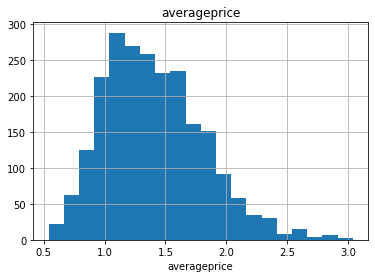

count    2.281000e+03
mean     7.938820e+05
std      3.017737e+06
min      8.456000e+01
5%       2.391740e+03
10%      4.292520e+03
20%      9.057290e+03
30%      1.849423e+04
40%      5.366333e+04
50%      1.142756e+05
60%      2.025531e+05
70%      3.219959e+05
80%      6.155807e+05
90%      1.395562e+06
95%      3.854100e+06
99%      7.639635e+06
max      4.293982e+07
Name: total volume, dtype: float64


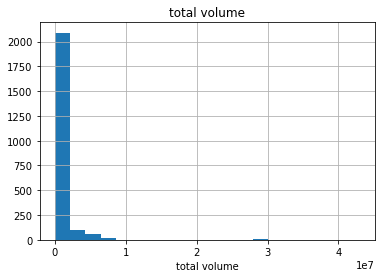

count    2.281000e+03
mean     2.717054e+05
std      1.134976e+06
min      0.000000e+00
5%       3.126000e+01
10%      1.112000e+02
20%      6.687700e+02
30%      1.759680e+03
40%      3.668070e+03
50%      9.145920e+03
60%      3.417358e+04
70%      8.001989e+04
80%      1.552886e+05
90%      5.568148e+05
95%      1.194635e+06
99%      3.372096e+06
max      1.600011e+07
Name: 4046, dtype: float64


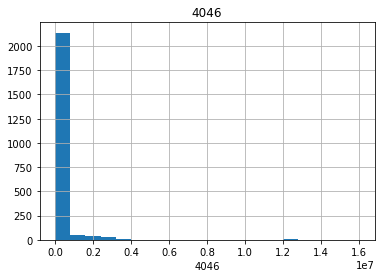

count    2.281000e+03
mean     2.747562e+05
std      1.048155e+06
min      0.000000e+00
5%       1.032400e+02
10%      4.783100e+02
20%      2.269130e+03
30%      4.853370e+03
40%      1.387067e+04
50%      3.226219e+04
60%      5.640632e+04
70%      1.030663e+05
80%      2.239140e+05
90%      4.929153e+05
95%      1.308748e+06
99%      2.921823e+06
max      1.424560e+07
Name: 4225, dtype: float64


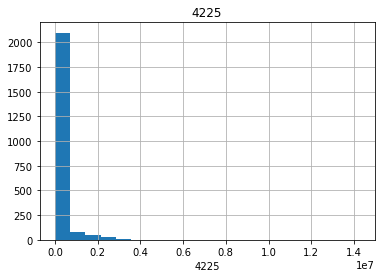

count    2.281000e+03
mean     2.087663e+04
std      8.628548e+04
min      0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
20%      0.000000e+00
30%      2.650000e+00
40%      4.990000e+01
50%      2.031600e+02
60%      9.347800e+02
70%      3.974430e+03
80%      1.237919e+04
90%      3.302348e+04
95%      1.068257e+05
99%      4.240140e+05
max      1.326423e+06
Name: 4770, dtype: float64


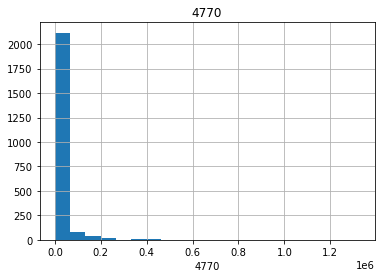

count    2.281000e+03
mean     2.265414e+05
std      8.549313e+05
min      0.000000e+00
5%       5.999800e+02
10%      1.338160e+03
20%      3.983100e+03
30%      8.738860e+03
40%      1.911640e+04
50%      4.162305e+04
60%      6.266362e+04
70%      8.806705e+04
80%      1.452313e+05
90%      4.337200e+05
95%      1.123519e+06
99%      2.761390e+06
max      1.386246e+07
Name: total bags, dtype: float64


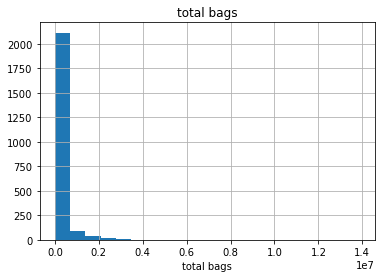

count    2.281000e+03
mean     1.750574e+05
std      6.498979e+05
min      0.000000e+00
5%       2.700000e+02
10%      5.805600e+02
20%      1.812850e+03
30%      5.955980e+03
40%      1.378066e+04
50%      2.849878e+04
60%      4.861954e+04
70%      7.037752e+04
80%      1.071749e+05
90%      3.591455e+05
95%      8.564523e+05
99%      2.116417e+06
max      1.004124e+07
Name: small bags, dtype: float64


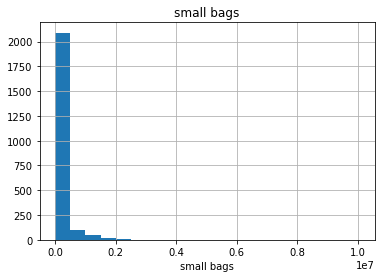

count    2.281000e+03
mean     4.840554e+04
std      2.115920e+05
min      0.000000e+00
5%       0.000000e+00
10%      0.000000e+00
20%      2.907000e+01
30%      3.402800e+02
40%      1.063920e+03
50%      2.684180e+03
60%      5.958070e+03
70%      1.347499e+04
80%      3.464193e+04
90%      9.457287e+04
95%      1.924253e+05
99%      8.321083e+05
max      3.917570e+06
Name: large bags, dtype: float64


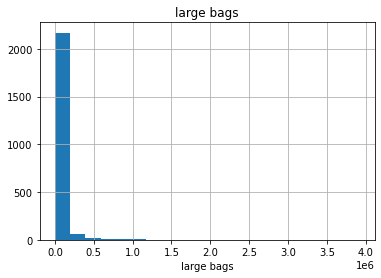

count      2281.000000
mean       3078.448238
std       15958.991326
min           0.000000
5%            0.000000
10%           0.000000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           0.000000
70%          54.540000
80%         746.430000
90%        3754.420000
95%       15079.490000
99%       62180.694000
max      377661.060000
Name: xlarge bags, dtype: float64


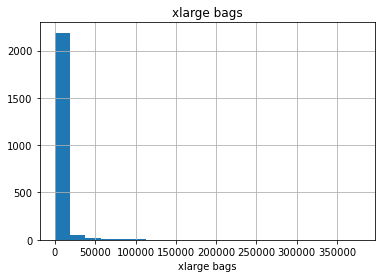

In [994]:
for col in num_cols:
    num_summary(df,col,plot=True)

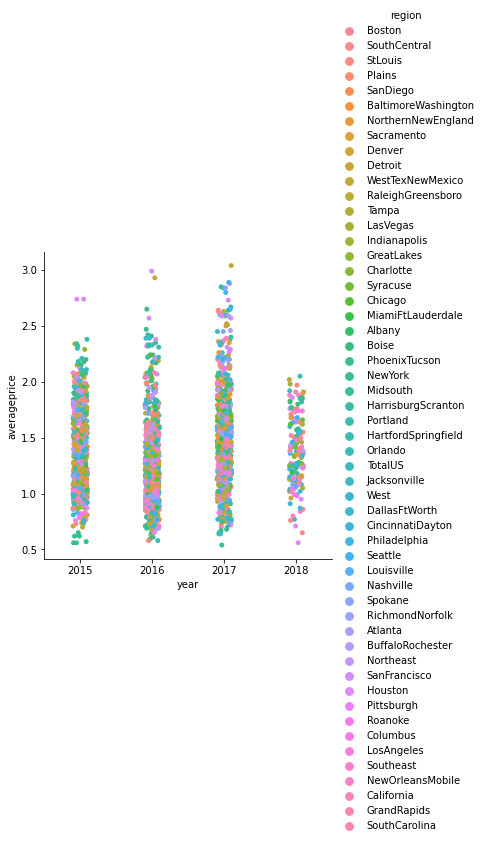

In [995]:
sns.catplot(x="year",y="averageprice",hue="region",data=df);

*Absolutely it looks like so confused for everyone.However,we need to examine our datas by groupby function*

In [996]:
df.groupby(['region','year']).sum()

averageprice  total volume        4046        4225  \
region           year                                                       
Albany           2015         25.07     927844.35    11276.79   737370.28   
                 2016         20.23     647468.90    72773.90   487701.28   
                 2017         19.89     641307.15    23564.12   517634.20   
                 2018          2.60     366134.97    23987.34   304770.09   
Atlanta          2015          8.16    1627188.85  1202439.43   181790.06   
...                             ...           ...         ...         ...   
West             2017          8.60   24190443.43  8356016.15  5461909.40   
                 2018          3.23     536414.95    54562.53   138244.96   
WestTexNewMexico 2015         14.76    4936553.32  3398280.23   857001.30   
                 2016         21.17   11009235.85  6461816.42  1240613.94   
                 2017         23.41    6299026.54  3505229.79   760761.10   

                            4770  total bags  small bags  large bags  \
region           year                                                  
Albany           2015    7137.93   172059.35   167179.19     4880.16   
                 2016     402.65    86591.07    83734.93     1146.14   
                 2017    1040.61    99068.22    69906.29    29161.93   
                 2018     208.98    37168.56    29845.40     6693.16   
Atlanta          2015    5542.70   237416.66   167905.12    69469.99   
...                          ...         ...         ...         ...   
West             2017  455633.62  9916885.26  5910872.95  3979913.31   
                 2018     393.98   343213.48   194282.93   148786.09   
WestTexNewMexico 2015   85564.27   595707.52   489615.40   106092.12   
                 2016  279872.53  3026932.96  1674422.76  1319863.26   
                 2017   72605.71  1960429.94   836550.66  1120431.17   

                       xlarge bags  
region           year               
Albany           2015         0.00  
                 2016      1710.00  
                 2017         0.00  
                 2018       630.00  
Atlanta          2015        41.55  
...                            ...  
West             2017     26099.00  
                 2018       144.46  
WestTexNewMexico 2015         0.00  
                 2016     32646.94  
                 2017      3448.11  

[212 rows x 9 columns]

**as you can see,there are so many region on our data set :(**

# Data Preparation

### Outlier Analysis

**Alright, let's  look inside of our data whether there are outliers.We check by analyzing graphs**

In [997]:
for col in num_cols:
    print("{} :  {}".format(col,check_outlier(df,col)))
    grab_outliers(df,col)

averageprice :  True
       averageprice  total volume     4046      4225  4770  total bags  \
17032          2.80      27717.86  1079.70  11176.20   7.6    15454.36   
16993          2.59      12279.96  4003.36   5495.51   0.0     2781.09   
14118          2.57      14537.83  4731.38   7497.35   0.0     2309.10   
14811          2.59      17990.83   538.17   5588.70   0.0    11863.96   
17008          2.88      18687.22  6332.48   9140.83  11.7     3202.21   

       small bags  large bags  xlarge bags     type  year        region  
17032     1402.31    14045.01         7.04  organic  2017       Seattle  
16993     2765.59       15.50         0.00  organic  2017  SanFrancisco  
14118     2309.10        0.00         0.00  organic  2016  SanFrancisco  
14811     3850.84     8013.12         0.00  organic  2017       Atlanta  
17008     3202.21        0.00         0.00  organic  2017  SanFrancisco  
total volume :  True
      averageprice  total volume        4046        4225       4770  

## Outlier Processing

In [998]:
for col in num_cols:
    replace_with_thresholds(df,col)

***Let's check whether outliers of variables one more time***

In [999]:
for col in num_cols:
    print(check_outlier(df,col))

False
False
False
False
False
False
False
False
False


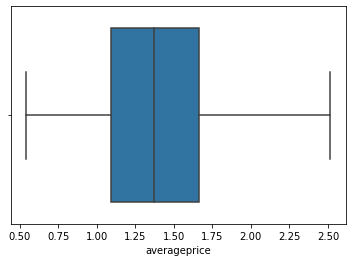

In [1000]:
sns.boxplot(x=df.averageprice);

**We have checked value of price_wheat_ton both functionally and visually**

In [1001]:
df.describe()

,averageprice,total volume,4046,4225,4770,total bags,small bags,large bags,xlarge bags,year
count,2281.000000,2.281000e+03,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000
mean,1.401032,2.911772e+05,70115.236602,102000.496607,4360.730445,78683.668498,58872.018126,13959.996502,146.787602,2016.147304
std,0.398741,3.674503e+05,99115.210891,136190.085489,6636.089601,92704.430189,70566.316143,19657.581830,243.155272,0.935299
min,0.540000,8.456000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2015.000000
25%,1.090000,1.241085e+04,1131.670000,3430.990000,0.000000,6044.110000,3226.340000,115.530000,0.000000,2015.000000
50%,1.370000,1.142756e+05,9145.920000,32262.190000,203.160000,41623.050000,28498.780000,2684.180000,0.000000,2016.000000
75%,1.660000,4.329623e+05,110762.280000,155813.570000,6901.710000,111269.760000,85697.330000,21328.120000,236.670000,2017.000000
max,2.515000,1.063789e+06,275208.195000,384387.440000,17254.275000,269108.235000,209403.815000,53147.005000,591.675000,2018.000000


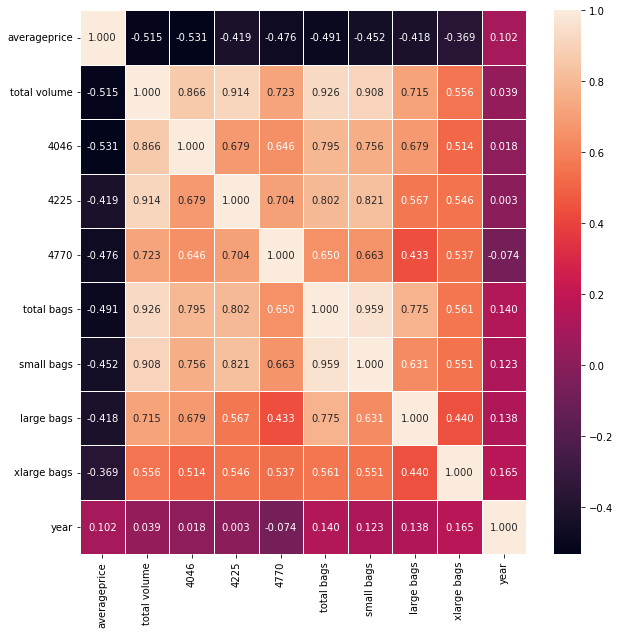

In [1002]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,fmt=".3f",linewidth=.5,cbar=True);

## Feature Engineering

In [1003]:
categories=["Very Low","Low","Avarage","High","Very High"]

In [1004]:
df["total_income"]=df["averageprice"]*df["total volume"]
df["reveneu_status"]=pd.cut(df["total_income"],len(categories),labels=categories)
df.head(30)

,averageprice,total volume,4046,4225,4770,total bags,small bags,large bags,xlarge bags,type,year,region,total_income,reveneu_status
235,1.24,543504.66,3582.450,384387.44,8899.200,126114.480,125821.150,293.330,0.000,conventional,2015,Boston,6.739458e+05,Low
12172,1.57,18030.82,8.230,593.13,0.000,17429.460,15470.610,1958.850,0.000,organic,2016,Boston,2.830839e+04,Very Low
5192,0.82,1063789.45,275208.195,384387.44,17254.275,269108.235,209403.815,53147.005,591.675,conventional,2016,SouthCentral,8.723073e+05,Avarage
17289,1.81,6102.50,804.300,1175.92,0.000,4122.280,1492.220,2630.060,0.000,organic,2017,StLouis,1.104552e+04,Very Low
10955,1.64,30717.28,3595.240,13212.07,311.490,13598.480,7405.560,6192.920,0.000,organic,2015,Plains,5.037634e+04,Very Low
7813,1.48,449543.62,181912.690,134913.99,17254.275,110278.440,102399.170,4884.600,591.675,conventional,2017,SanDiego,6.653246e+05,Low
144,1.10,808897.21,65158.960,384387.44,17254.275,176385.620,171699.950,4685.670,0.000,conventional,2015,BaltimoreWashington,8.897869e+05,Avarage
16332,1.76,25227.40,0.000,463.23,0.000,24764.170,24764.170,0.000,0.000,organic,2017,NorthernNewEngland,4.440022e+04,Very Low
7751,1.61,354589.37,124583.840,189307.81,912.400,39785.320,39044.800,587.020,153.500,conventional,2017,Sacramento,5.708889e+05,Low
10989,1.70,36993.47,5052.360,17469.75,18.330,14453.030,13506.710,946.320,0.000,organic,2015,Plains,6.288890e+04,Very Low


In [1005]:
df.reveneu_status.value_counts()

Very Low     1596
Low           320
Avarage       240
High           98
Very High      27
Name: reveneu_status, dtype: int64

## Encoding

### One hot Encoding

In [1006]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2281 entries, 235 to 8675
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   averageprice    2281 non-null   float64 
 1   total volume    2281 non-null   float64 
 2   4046            2281 non-null   float64 
 3   4225            2281 non-null   float64 
 4   4770            2281 non-null   float64 
 5   total bags      2281 non-null   float64 
 6   small bags      2281 non-null   float64 
 7   large bags      2281 non-null   float64 
 8   xlarge bags     2281 non-null   float64 
 9   type            2281 non-null   object  
 10  year            2281 non-null   int64   
 11  region          2281 non-null   object  
 12  total_income    2281 non-null   float64 
 13  reveneu_status  2281 non-null   category
dtypes: category(1), float64(10), int64(1), object(2)
memory usage: 316.5+ KB


In [1007]:
ohe_cols=[col for col in df.columns if 80 >=df[col].nunique()>=2]
df=one_hot_encoder(df,ohe_cols,True)


In [1008]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2281 entries, 235 to 8675
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   averageprice                2281 non-null   float64
 1   total volume                2281 non-null   float64
 2   4046                        2281 non-null   float64
 3   4225                        2281 non-null   float64
 4   4770                        2281 non-null   float64
 5   total bags                  2281 non-null   float64
 6   small bags                  2281 non-null   float64
 7   large bags                  2281 non-null   float64
 8   xlarge bags                 2281 non-null   float64
 9   total_income                2281 non-null   float64
 10  type_organic                2281 non-null   uint8  
 11  year_2016                   2281 non-null   uint8  
 12  year_2017                   2281 non-null   uint8  
 13  year_2018                   228

**We need to check what  kind of data  we have.Apparently, variable of region has so many different types.Therefore,we have associated  variable counts of region to onehotencoding**

In [1009]:
cat_cols,num_cols,cat_but_car,num_but_car=grab_col_names(df)

Observations: 2281
Variables: 71
cat_cols: 61
num_cols: 10
cat_but_car: 0
num_but_cat: 61


In [1010]:
ohe_cols

['type', 'year', 'region', 'reveneu_status']

In [1011]:
df.describe()

,averageprice,total volume,4046,4225,4770,total bags,small bags,large bags,xlarge bags,total_income,...,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,reveneu_status_Low,reveneu_status_Avarage,reveneu_status_High,reveneu_status_Very High
count,2281.000000,2.281000e+03,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2.281000e+03,...,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000,2281.000000
mean,1.401032,2.911772e+05,70115.236602,102000.496607,4360.730445,78683.668498,58872.018126,13959.996502,146.787602,3.324585e+05,...,0.019290,0.014906,0.022797,0.014029,0.017098,0.021043,0.140289,0.105217,0.042964,0.011837
std,0.398741,3.674503e+05,99115.210891,136190.085489,6636.089601,92704.430189,70566.316143,19657.581830,243.155272,4.120065e+05,...,0.137572,0.121202,0.149289,0.117636,0.129664,0.143560,0.347363,0.306900,0.202820,0.108175
min,0.540000,8.456000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.344504e+02,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.090000,1.241085e+04,1131.670000,3430.990000,0.000000,6044.110000,3226.340000,115.530000,0.000000,1.987257e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.370000,1.142756e+05,9145.920000,32262.190000,203.160000,41623.050000,28498.780000,2684.180000,0.000000,1.560859e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.660000,4.329623e+05,110762.280000,155813.570000,6901.710000,111269.760000,85697.330000,21328.120000,236.670000,5.156089e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.515000,1.063789e+06,275208.195000,384387.440000,17254.275000,269108.235000,209403.815000,53147.005000,591.675000,1.957373e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Feature Scaling

In [1012]:
transform_power = RobustScaler()
df[num_cols] = transform_power.fit_transform(df[num_cols])
df.head()

,averageprice,total volume,4046,4225,4770,total bags,small bags,large bags,xlarge bags,total_income,...,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,reveneu_status_Low,reveneu_status_Avarage,reveneu_status_High,reveneu_status_Very High
235,-0.228070,1.020634,-0.050747,2.310797,1.259983,0.802955,1.180080,-0.112709,0.0,1.044628,...,0,0,0,0,0,0,1,0,0,0
12172,0.350877,-0.228854,-0.083350,-0.207826,-0.029436,-0.229921,-0.157973,-0.034193,0.0,-0.257753,...,0,0,0,0,0,0,0,0,0,0
5192,-0.964912,2.257783,2.426898,2.310797,2.470564,2.161880,2.193560,2.378909,2.5,1.444763,...,0,0,0,0,0,0,0,1,0,0
17289,0.771930,-0.257217,-0.076088,-0.204001,-0.029436,-0.356384,-0.327467,-0.002551,0.0,-0.292576,...,1,0,0,0,0,0,0,0,0,0
10955,0.473684,-0.198688,-0.050631,-0.125015,0.015696,-0.266328,-0.255765,0.165408,0.0,-0.213238,...,0,0,0,0,0,0,0,0,0,0


<a id="11"></a>
# Modeling

In [1013]:
from sklearn.linear_model import LinearRegression

y = df.averageprice
X = df.drop(['averageprice'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=17)

In [1014]:
def train_model(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    return model, y_pred

**Ok,we gonna use  regression models**

In [1015]:
# Cross validate model with Kfold stratified cross val
kfold = KFold(n_splits=10,shuffle=True)

In [1016]:
Lin_reg,y_pred=train_model(LinearRegression(),X_train,y_train,X_test)

In [1017]:
Lin_reg.score(X_test,y_test)

0.7077016306272237

In [1018]:
RFM_reg,y_pred=train_model(RandomForestRegressor(),X_train,y_train,X_test)

In [1019]:
RFM_reg.score(X_test,y_test)

0.813348915653928

In [1020]:
Gradient_reg,y_pred=train_model(GradientBoostingRegressor(),X_train,y_train,X_test)

In [1021]:
Gradient_reg.score(X_test,y_test)

0.7587478556921684

In [1022]:
Extra_reg,y_pred=train_model(ExtraTreesRegressor(),X_train,y_train,X_test)

In [1023]:
Extra_reg.score(X_test,y_test)

0.8016677226054213

In [1024]:
Dec_reg,y_pred=train_model(DecisionTreeRegressor(),X_train,y_train,X_test)

In [1025]:
Dec_reg.score(X_test,y_test)

0.6873546563555288

In [1026]:
Adabost_reg,y_pred=train_model(AdaBoostRegressor(),X_train,y_train,X_test)

In [1027]:
Adabost_reg.score(X_test,y_test)

0.5989749212857669

In [1028]:
Lgbm_reg,y_pred=train_model(LGBMRegressor(),X_train,y_train,X_test)

In [1029]:
Lgbm_reg.score(X_test,y_test)

0.9106378325862974